## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally install and import torchensemble package for ensemble learning

In [16]:
# For Colab users
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# For import .py file
# you can copy path using right click - path copy
import sys
sys.path.insert(0,'/content/drive/MyDrive/final_proj_colab/normal')
# sys.path.insert(0,'/content/drive/MyDrive/final_proj_colab/normal')

Mounted at /content/drive


In [17]:
import os
import numpy as np
import torch
import torch.nn as nn
import random  
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import importlib

## (Optional) Sample Visualization
You can see actual sample images and sorted class indices. Additional matplotlib package is needed.

In [18]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

alphabet = {
        'A(a)' : '0', 'B(b)' : '1', 'C(c)' : '2', 'D(d)' : '3', 'E(e)' : '4', 'F(f)' : '5', 
        'G(g)' : '6', 'H(h)' : '7', 'I(i)' : '8', 'J(j)' : '9', 'K(k)' : '10','L(l)' : '11', 
        'M(m)' : '12', 'N(n)' : '13', 'O(o)' : '14', 'P(p)' : '15', 'Q(q)' : '16', 'R(r)' : '17', 
        'S(s)' : '18', 'T(t)' : '19', 'U(u)' : '20', 'V(v)' : '21', 'W(w)' : '22', 'X(x)' : '23', 
        'Y(y)' : '24', 'Z(z)' : '25'
    }

7


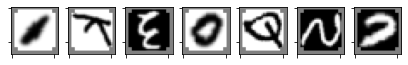

progress label:  8 10 12 14 16 18 20 22 
( I(i) K(k) M(m) O(o) Q(q) S(s) U(u) W(w) )


In [19]:
# Just for reference: see actual samples

# load_sample = np.load('./data/emnist_progress_normal_data/sample_data.npy', allow_pickle=True).item()
load_sample = np.load('/content/drive/MyDrive/final_proj_colab/emnist_progress_normal_data/sample_data.npy', allow_pickle=True).item()
sample_data, sample_label = load_sample['train_data'], load_sample['train_label']
print(len(sample_data))


plt.figure(figsize=(len(sample_data),len(sample_data)))
for i in range(len(sample_data)):
    plt.subplot(1, len(sample_data), i+1)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.imshow(sample_data[i], cmap='gray')
    
plt.show()
print("progress label: ", end=' ')
label_str = '('

for i in range(len(sample_label)):
    print(int(sample_label[i]), end=' ')
    label_str += " " + list(alphabet.keys())[int(sample_label[i])]
label_str += " )"
print()
print(label_str)

In [20]:
# Use 0th GPU for training
torch.cuda.set_device(0)

In [21]:
# fix random seed to increase reproducibility
# NOTE: Do not modify here!

random_seed = 7
torch.manual_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
%env CUBLAS_WORKSPACE_CONFIG=:16:8

def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
# you can modify this
num_workers = 1

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [22]:
# NOTE: you can modify mean and std for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.RandomRotation((-5, 5)),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomInvert(0.2),
    transforms.Normalize((0.1307,), (0.3081,)),
])

batch_size = 40

In [23]:
# NOTE: modify path for your setting
from data_utils import Mydataset, collate_fn

# train_path = './data/emnist_progress_normal_data/train'
# valid_path = './data/emnist_progress_normal_data/valid'
train_path = '/content/drive/MyDrive/final_proj_colab/emnist_progress_normal_data/train'
valid_path = '/content/drive/MyDrive/final_proj_colab/emnist_progress_normal_data/valid'

train_ds = Mydataset(train_path, transform=transform, train=True)
valid_ds = Mydataset(valid_path, transform=transform, train=False)

train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valid_dl= DataLoader(valid_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

0 load from 0 to 5000
1 load from 5000 to 10000
2 load from 10000 to 15000
3 load from 15000 to 20000
4 load from 20000 to 25000
5 load from 25000 to 30000
6 load from 30000 to 35000
7 load from 35000 to 40000
8 load from 40000 to 45000
9 load from 45000 to 50000
0 load from 0 to 5000
1 load from 5000 to 10000


In [29]:
import time

def train(model, model_optim, loss_func, max_epoch, train_dl, valid_dl, 
          load_path=None, save_path='./drive/MyDrive/final_proj_colab/normal/model_normal.pt'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Load your states
    
    loaded_epoch = 0
    loaded_loss1_list = None
    loaded_loss2_list = None
    loaded_loss_list = None
    loaded_gru1_acc_list = None
    loaded_gru2_acc_list = None
    loaded_train_acc_list = None
    loaded_valid_acc_list = None

    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_loss1_list = state["loss1_list"]
        loaded_loss2_list = state["loss2_list"]
        loaded_loss_list = state["loss_list"]
        loaded_gru1_acc_list = state["gru1_acc_list"]
        loaded_gru2_acc_list = state["gru2_acc_list"]
        loaded_train_acc_list = state["train_acc_list"]
        loaded_valid_acc_list = state["valid_acc_list"]
        # ...
    start_time = time.time()
        
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
    
    loss1_list = [] if loaded_loss1_list == None else loaded_loss1_list
    loss2_list = [] if loaded_loss2_list == None else loaded_loss2_list
    loss_list = [] if loaded_loss_list == None else loaded_loss_list
    gru1_acc_list = [] if loaded_gru1_acc_list == None else loaded_gru1_acc_list
    gru2_acc_list = [] if loaded_gru2_acc_list == None else loaded_gru2_acc_list
    train_acc_list = [] if loaded_train_acc_list == None else loaded_train_acc_list
    valid_acc_list = [] if loaded_valid_acc_list == None else loaded_valid_acc_list

    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        for step, sample in enumerate(train_dl):
            model.train()
            img, label = sample
            outputs = model((img, label))
            
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Problem 4: implement optimization part            
            if torch.cuda.is_available():
              device = 'cuda'
            else:
              device = 'cpu'

            batch_size = len(label)

            sequence_length_max = 0
            for i in range(batch_size):
              if sequence_length_max < len(label[i])-1:
                sequence_length_max = len(label[i])-1

            output1, output2 = outputs


            y1 = torch.zeros(batch_size, sequence_length_max, 26).to(device)
            y2 = torch.zeros(batch_size, sequence_length_max, 26).to(device)

            for i in range(batch_size):
              for j in range(len(label[i])):
                if j != len(label[i])-1:
                  y1[i][j] = nn.functional.one_hot(torch.LongTensor(label[i][j]), num_classes = 26)  
                  # one_hot = nn.functional.one_hot(torch.LongTensor(label[i][j]), num_classes = 26)  
                  # soft_label = one_hot * (1 - 0.1) + (0.1 / 26)
                  # y1[i][j] = soft_label
                if j != 0:
                  # y2[i][j-1] = nn.functional.one_hot(torch.LongTensor(label[i][j]), num_classes = 26)
                  one_hot = nn.functional.one_hot(torch.LongTensor(label[i][j]), num_classes = 26)  
                  soft_label = one_hot * (1 - 0.2) + (0.2 / 26)
                  y2[i][j-1] = soft_label
            
            # epsilon = 1e-10
            epsilon = 0
            output1_review = epsilon + torch.zeros(batch_size, sequence_length_max, 26).to(device)
            output2_review = epsilon + torch.zeros(batch_size, sequence_length_max, 26).to(device)

            for i in range(batch_size):
              output1_review[i, range(output1[i].shape[0]), :] = output1[i]
              output2_review[i, range(output2[i].shape[0]), :] = output2[i]


            loss1 = loss_func(output1_review, y1)
            loss2 = loss_func(output2_review, y2)
            
            loss = (loss1 + loss2) / 2
            
            model_optim.zero_grad()
            loss.backward()
            model_optim.step()


            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            
            # you can modify below train evaluation code
            
            if (step + 1) % print_interval == 0:
              n_samples1 = 0
              n_samples2 = 0
              n_samples3 = 0

              n_correct1 = 0
              n_correct2 = 0
              n_correct3 = 0
              n_correct4 = 0

              with torch.no_grad():
                model.eval()
                for i in range(batch_size):
                  n_samples1 += len(label[i])
                  n_correct1 += (output1[i].argmax(-1) == label[i][0:-1].cuda()).sum().item()            
                  n_correct2 += (output2[i].argmax(-1) == label[i][1:].cuda()).sum().item()            

                n_samples2 += batch_size
                for i in range(batch_size):
                  n_correct3 += (output2[i][-1].argmax() == label[i][-1].cuda()).item()


                for _, sample in enumerate(valid_dl):
                  img, label = sample            
                  outputs = model(img)
                  n_samples3 += batch_size
                  for i in range(batch_size):
                    n_correct4 += (outputs[i].argmax() == label[i][-1].cuda()).sum().item()

                loss1_list.append(loss1.item())
                loss2_list.append(loss2.item())
                loss_list.append(loss.item())                
                gru1_acc_list.append(100 * (n_correct1 / n_samples1))
                gru2_acc_list.append(100 * (n_correct2 / n_samples1))
                train_acc_list.append(100 * (n_correct3 / n_samples2))
                valid_acc_list.append(100 * (n_correct4 / n_samples3))
                
                print('epoch:', epoch + 1, 'step:', step + 1, 'loss1:', loss1.item(), 'loss2:', loss2.item(), 'loss:', loss.item())
                print('cnn-gru1 accuracy:', 100 * (n_correct1 / n_samples1), 'gru2 accuracy', 100 * (n_correct2 / n_samples1), 'training accuracy', 100 * (n_correct3 / n_samples2), 'validation accuracy', 100 * (n_correct4/n_samples3))
                elapsed_time = time.time() - start_time
                print('elapsed time : %d h %d m %d s' % (elapsed_time / 3600, (elapsed_time % 3600) / 60, (elapsed_time % 60)))            


        # you can modify evaluation code
                
        n_samples = 0
        n_correct = 0
        with torch.no_grad():
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                # Save your states (optional)
                state = {
                    "model": model.state_dict(),
                    "optimizer": model_optim.state_dict(),
                    "epoch": epoch + 1,                                
                    "loss1_list": loss1_list,
                    "loss2_list": loss2_list,
                    "loss_list": loss_list,
                    "gru1_acc_list": gru1_acc_list,
                    "gru2_acc_list": gru2_acc_list,
                    "train_acc_list": train_acc_list,
                    "valid_acc_list": valid_acc_list
                    # ...
                }
                ##############################################################################
                #                          END OF YOUR CODE                                  #
                ##############################################################################
                torch.save(state, save_path)
# you can modify evaluation code

def eval(valid_dl, load_path):
    state = torch.load(load_path)
    model.load_state_dict(state["model"])
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Problem 5: implement evaluation part
    # you can simply copy or modify above evaluation code in train function

    n_samples = 0
    n_correct = 0

    for step, sample in enumerate(valid_dl):
        img, label = sample
        outputs = model(img)
        
        n_samples += batch_size
        for i in range(batch_size):
            n_correct += (outputs[i].argmax(-1) == label[i][-1].cuda()).sum().item()
            #
            if (outputs[i].argmax(-1) == label[i][-1].cuda()).sum().item() == 0:
              sample_data = []
              for iter in range(len(img[i])):
                sample_data.append(img[i][iter][0])
              sample_label = label[i]
              plt.figure(figsize=(len(sample_data),len(sample_data)))
              for i in range(len(sample_data)):
                  plt.subplot(1, len(sample_data), i+1)
                  ax = plt.gca()
                  ax.axes.xaxis.set_ticklabels([])
                  ax.axes.yaxis.set_ticklabels([])
                  plt.imshow(sample_data[i], cmap='gray')
                  
              plt.show()
              print("progress label: ", end=' ')
              label_str = '('

              for j in range(len(sample_label)):
                  print(int(sample_label[j]), end=' ')
                  label_str += " " + list(alphabet.keys())[int(sample_label[j])]
              label_str += " )"
              print()
              print(label_str)
              print(outputs[i].argmax(-1))
            #
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
        
    valid_accuracy = 100 * (n_correct / n_samples)
    print('Valid accuracy: %.2f' % (valid_accuracy))

In [30]:
# You can add or modify your ConvLSTM's hyperparameter (keys and values)

kwargs = {
    'cnn_input_dim': 1,
    'cnn_hidden_size': 32,
    'rnn_input_dim': 512,
    'rnn_hidden_size': 256,
    'rnn_num_layers': 2,
    'rnn_dropout': 0.00
}

NUM_CLASSES = 26
SEQUENCE_LENGTH = None

In [31]:
# for reload .py file without restart
import models_normal
importlib.reload(models_normal)

from models_normal import ConvGRU

model = ConvGRU(sequence_length=None, num_classes=NUM_CLASSES, **kwargs).cuda()
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
model_optim = torch.optim.Adam(model.parameters(), lr=0.00008)
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()

"""
def init_normal(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform(m.weight)
    m.bias.data.fill_(0.001)

model.apply(init_normal)
"""
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

ConvGRU(
  (conv): CustomCNN(
    (layer1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer5): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1

'\ndef init_normal(m):\n  if type(m) == nn.Linear:\n    torch.nn.init.xavier_uniform(m.weight)\n    m.bias.data.fill_(0.001)\n\nmodel.apply(init_normal)\n'

In [32]:
# NOTE: you can modify hyperparameters

print_interval = 50
max_epoch = 12

In [ ]:
load_path = './drive/MyDrive/final_proj_colab/normal/model_normal.pt'
# load_path = None
train(model, model_optim, loss_func, max_epoch, train_dl, valid_dl, load_path=load_path, save_path='./drive/MyDrive/final_proj_colab/normal/model_normal.pt')

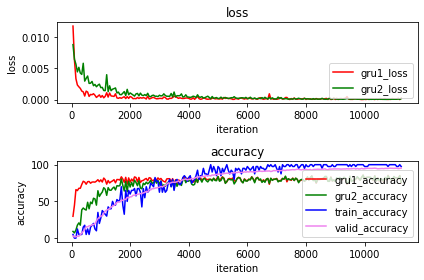

In [45]:
load_path = './drive/MyDrive/final_proj_colab/normal/model_normal.pt'
state = torch.load(load_path)

loss1_list = state["loss1_list"]
loss2_list = state["loss2_list"]
loss_list = state["loss_list"]
gru1_acc_list = state["gru1_acc_list"]
gru2_acc_list = state["gru2_acc_list"]
train_acc_list = state["train_acc_list"]
valid_acc_list = state["valid_acc_list"]

import matplotlib.pyplot as plt

x = []
for i in range(len(loss1_list)):
  x.append(50 * (i+1))

max = 225

plt.subplot(2, 1, 1)
plt.title('loss')
plt.plot(x[:max], loss1_list[:max], 'r', label='gru1_loss')
plt.plot(x[:max], loss2_list[:max], 'g', label='gru2_loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.title('accuracy')
plt.plot(x[:max], gru1_acc_list[:max], 'r', label='gru1_accuracy')
plt.plot(x[:max], gru2_acc_list[:max], 'g', label='gru2_accuracy')
plt.plot(x[:max], train_acc_list[:max], 'b', label='train_accuracy')
plt.plot(x[:max], valid_acc_list[:max], 'violet', label='valid_accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


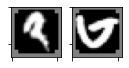

progress label:  0 3 6 
( A(a) D(d) G(g) )
tensor(19, device='cuda:0')


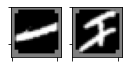

progress label:  8 7 6 
( I(i) H(h) G(g) )
tensor(19, device='cuda:0')


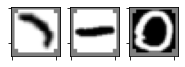

progress label:  8 11 14 17 
( I(i) L(l) O(o) R(r) )
tensor(12, device='cuda:0')


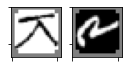

progress label:  10 16 22 
( K(k) Q(q) W(w) )
tensor(20, device='cuda:0')


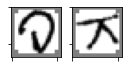

progress label:  6 10 14 
( G(g) K(k) O(o) )
tensor(9, device='cuda:0')


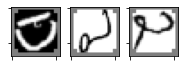

progress label:  3 6 9 12 
( D(d) G(g) J(j) M(m) )
tensor(15, device='cuda:0')


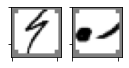

progress label:  13 8 3 
( N(n) I(i) D(d) )
tensor(1, device='cuda:0')


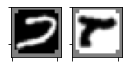

progress label:  20 17 14 
( U(u) R(r) O(o) )
tensor(1, device='cuda:0')


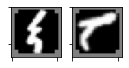

progress label:  12 17 22 
( M(m) R(r) W(w) )
tensor(20, device='cuda:0')


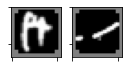

progress label:  5 8 11 
( F(f) I(i) L(l) )
tensor(7, device='cuda:0')


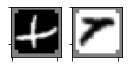

progress label:  19 21 23 
( T(t) V(v) X(x) )
tensor(7, device='cuda:0')


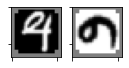

progress label:  6 4 2 
( G(g) E(e) C(c) )
tensor(7, device='cuda:0')


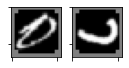

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(6, device='cuda:0')


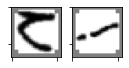

progress label:  13 9 5 
( N(n) J(j) F(f) )
tensor(6, device='cuda:0')


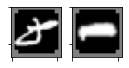

progress label:  15 11 7 
( P(p) L(l) H(h) )
tensor(6, device='cuda:0')


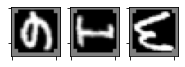

progress label:  4 8 12 16 
( E(e) I(i) M(m) Q(q) )
tensor(12, device='cuda:0')


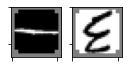

progress label:  8 12 16 
( I(i) M(m) Q(q) )
tensor(18, device='cuda:0')


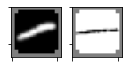

progress label:  8 11 14 
( I(i) L(l) O(o) )
tensor(18, device='cuda:0')


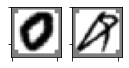

progress label:  14 18 22 
( O(o) S(s) W(w) )
tensor(18, device='cuda:0')


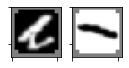

progress label:  13 8 3 
( N(n) I(i) D(d) )
tensor(7, device='cuda:0')


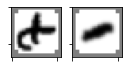

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(7, device='cuda:0')


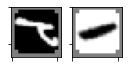

progress label:  7 11 15 
( H(h) L(l) P(p) )
tensor(7, device='cuda:0')


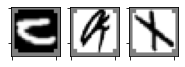

progress label:  13 16 19 22 
( N(n) Q(q) T(t) W(w) )
tensor(11, device='cuda:0')


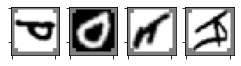

progress label:  1 3 5 7 9 
( B(b) D(d) F(f) H(h) J(j) )
tensor(24, device='cuda:0')


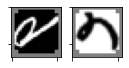

progress label:  6 4 2 
( G(g) E(e) C(c) )
tensor(12, device='cuda:0')


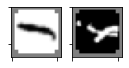

progress label:  11 9 7 
( L(l) J(j) H(h) )
tensor(12, device='cuda:0')


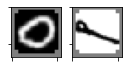

progress label:  14 16 18 
( O(o) Q(q) S(s) )
tensor(3, device='cuda:0')


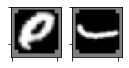

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(20, device='cuda:0')


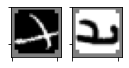

progress label:  23 24 25 
( X(x) Y(y) Z(z) )
tensor(20, device='cuda:0')


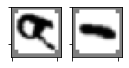

progress label:  17 11 5 
( R(r) L(l) F(f) )
tensor(20, device='cuda:0')


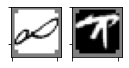

progress label:  16 10 4 
( Q(q) K(k) E(e) )
tensor(21, device='cuda:0')


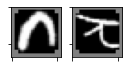

progress label:  2 7 12 
( C(c) H(h) M(m) )
tensor(21, device='cuda:0')


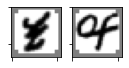

progress label:  12 6 0 
( M(m) G(g) A(a) )
tensor(7, device='cuda:0')


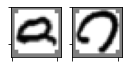

progress label:  0 2 4 
( A(a) C(c) E(e) )
tensor(13, device='cuda:0')


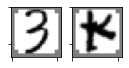

progress label:  22 19 16 
( W(w) T(t) Q(q) )
tensor(13, device='cuda:0')


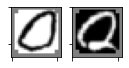

progress label:  14 19 24 
( O(o) T(t) Y(y) )
tensor(3, device='cuda:0')


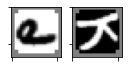

progress label:  6 10 14 
( G(g) K(k) O(o) )
tensor(3, device='cuda:0')


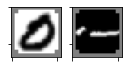

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(3, device='cuda:0')


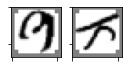

progress label:  16 10 4 
( Q(q) K(k) E(e) )
tensor(3, device='cuda:0')


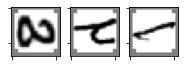

progress label:  6 7 8 9 
( G(g) H(h) I(i) J(j) )
tensor(25, device='cuda:0')


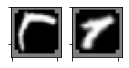

progress label:  17 21 25 
( R(r) V(v) Z(z) )
tensor(5, device='cuda:0')


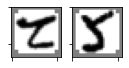

progress label:  7 13 19 
( H(h) N(n) T(t) )
tensor(5, device='cuda:0')


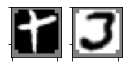

progress label:  19 22 25 
( T(t) W(w) Z(z) )
tensor(5, device='cuda:0')


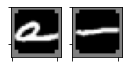

progress label:  6 11 16 
( G(g) L(l) Q(q) )
tensor(7, device='cuda:0')


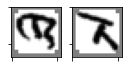

progress label:  4 10 16 
( E(e) K(k) Q(q) )
tensor(7, device='cuda:0')


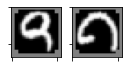

progress label:  0 2 4 
( A(a) C(c) E(e) )
tensor(7, device='cuda:0')


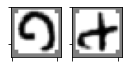

progress label:  2 5 8 
( C(c) F(f) I(i) )
tensor(7, device='cuda:0')


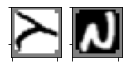

progress label:  24 18 12 
( Y(y) S(s) M(m) )
tensor(7, device='cuda:0')


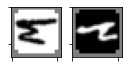

progress label:  12 7 2 
( M(m) H(h) C(c) )
tensor(2, device='cuda:0')


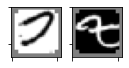

progress label:  21 16 11 
( V(v) Q(q) L(l) )
tensor(25, device='cuda:0')


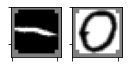

progress label:  11 14 17 
( L(l) O(o) R(r) )
tensor(25, device='cuda:0')


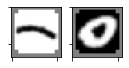

progress label:  11 14 17 
( L(l) O(o) R(r) )
tensor(25, device='cuda:0')


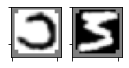

progress label:  20 22 24 
( U(u) W(w) Y(y) )
tensor(25, device='cuda:0')


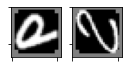

progress label:  16 18 20 
( Q(q) S(s) U(u) )
tensor(25, device='cuda:0')


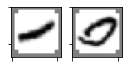

progress label:  8 14 20 
( I(i) O(o) U(u) )
tensor(25, device='cuda:0')


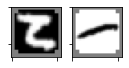

progress label:  13 8 3 
( N(n) I(i) D(d) )
tensor(25, device='cuda:0')


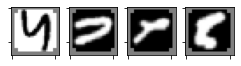

progress label:  25 21 17 13 9 
( Z(z) V(v) R(r) N(n) J(j) )
tensor(4, device='cuda:0')


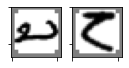

progress label:  9 13 17 
( J(j) N(n) R(r) )
tensor(2, device='cuda:0')


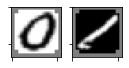

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(2, device='cuda:0')


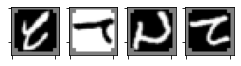

progress label:  13 11 9 7 5 
( N(n) L(l) J(j) H(h) F(f) )
tensor(1, device='cuda:0')


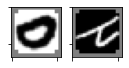

progress label:  3 7 11 
( D(d) H(h) L(l) )
tensor(24, device='cuda:0')


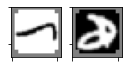

progress label:  11 8 5 
( L(l) I(i) F(f) )
tensor(7, device='cuda:0')


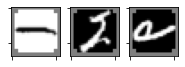

progress label:  8 12 16 20 
( I(i) M(m) Q(q) U(u) )
tensor(18, device='cuda:0')


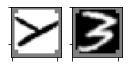

progress label:  24 22 20 
( Y(y) W(w) U(u) )
tensor(25, device='cuda:0')


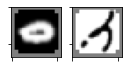

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(25, device='cuda:0')


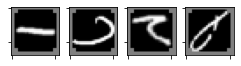

progress label:  11 9 7 5 3 
( L(l) J(j) H(h) F(f) D(d) )
tensor(15, device='cuda:0')


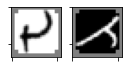

progress label:  9 7 5 
( J(j) H(h) F(f) )
tensor(25, device='cuda:0')


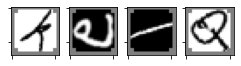

progress label:  1 6 11 16 21 
( B(b) G(g) L(l) Q(q) V(v) )
tensor(11, device='cuda:0')


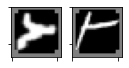

progress label:  17 19 21 
( R(r) T(t) V(v) )
tensor(20, device='cuda:0')


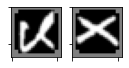

progress label:  25 23 21 
( Z(z) X(x) V(v) )
tensor(5, device='cuda:0')


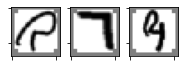

progress label:  6 11 16 21 
( G(g) L(l) Q(q) V(v) )
tensor(12, device='cuda:0')


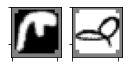

progress label:  5 3 1 
( F(f) D(d) B(b) )
tensor(16, device='cuda:0')


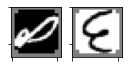

progress label:  16 12 8 
( Q(q) M(m) I(i) )
tensor(16, device='cuda:0')


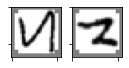

progress label:  25 20 15 
( Z(z) U(u) P(p) )
tensor(16, device='cuda:0')


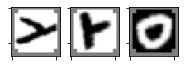

progress label:  24 19 14 9 
( Y(y) T(t) O(o) J(j) )
tensor(12, device='cuda:0')


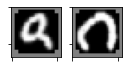

progress label:  0 2 4 
( A(a) C(c) E(e) )
tensor(1, device='cuda:0')


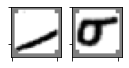

progress label:  11 15 19 
( L(l) P(p) T(t) )
tensor(1, device='cuda:0')


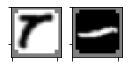

progress label:  17 21 25 
( R(r) V(v) Z(z) )
tensor(19, device='cuda:0')


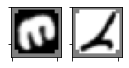

progress label:  4 8 12 
( E(e) I(i) M(m) )
tensor(19, device='cuda:0')


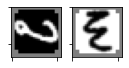

progress label:  6 12 18 
( G(g) M(m) S(s) )
tensor(19, device='cuda:0')


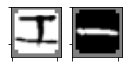

progress label:  7 11 15 
( H(h) L(l) P(p) )
tensor(9, device='cuda:0')


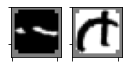

progress label:  9 5 1 
( J(j) F(f) B(b) )
tensor(9, device='cuda:0')


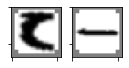

progress label:  13 8 3 
( N(n) I(i) D(d) )
tensor(9, device='cuda:0')


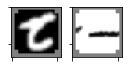

progress label:  13 9 5 
( N(n) J(j) F(f) )
tensor(9, device='cuda:0')


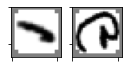

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(13, device='cuda:0')


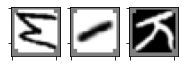

progress label:  12 11 10 9 
( M(m) L(l) K(k) J(j) )
tensor(24, device='cuda:0')


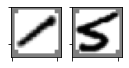

progress label:  8 13 18 
( I(i) N(n) S(s) )
tensor(13, device='cuda:0')


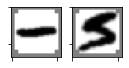

progress label:  11 13 15 
( L(l) N(n) P(p) )
tensor(18, device='cuda:0')


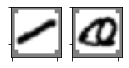

progress label:  11 16 21 
( L(l) Q(q) V(v) )
tensor(18, device='cuda:0')


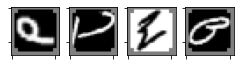

progress label:  6 9 12 15 18 
( G(g) J(j) M(m) P(p) S(s) )
tensor(18, device='cuda:0')


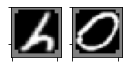

progress label:  8 14 20 
( I(i) O(o) U(u) )
tensor(1, device='cuda:0')


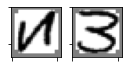

progress label:  25 22 19 
( Z(z) W(w) T(t) )
tensor(1, device='cuda:0')


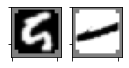

progress label:  13 8 3 
( N(n) I(i) D(d) )
tensor(1, device='cuda:0')


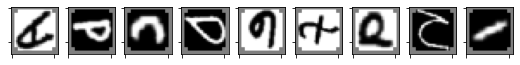

progress label:  0 1 2 3 4 5 6 7 8 9 
( A(a) B(b) C(c) D(d) E(e) F(f) G(g) H(h) I(i) J(j) )
tensor(17, device='cuda:0')


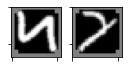

progress label:  25 24 23 
( Z(z) Y(y) X(x) )
tensor(24, device='cuda:0')


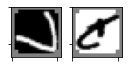

progress label:  9 5 1 
( J(j) F(f) B(b) )
tensor(24, device='cuda:0')


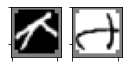

progress label:  10 5 0 
( K(k) F(f) A(a) )
tensor(5, device='cuda:0')


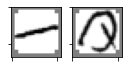

progress label:  11 16 21 
( L(l) Q(q) V(v) )
tensor(5, device='cuda:0')


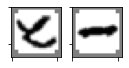

progress label:  13 11 9 
( N(n) L(l) J(j) )
tensor(14, device='cuda:0')


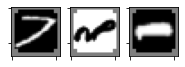

progress label:  21 16 11 6 
( V(v) Q(q) L(l) G(g) )
tensor(4, device='cuda:0')


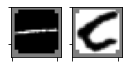

progress label:  11 13 15 
( L(l) N(n) P(p) )
tensor(14, device='cuda:0')


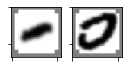

progress label:  11 14 17 
( L(l) O(o) R(r) )
tensor(14, device='cuda:0')


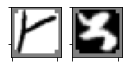

progress label:  19 20 21 
( T(t) U(u) V(v) )
tensor(2, device='cuda:0')


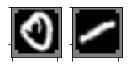

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(2, device='cuda:0')


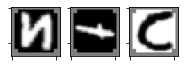

progress label:  25 19 13 7 
( Z(z) T(t) N(n) H(h) )
tensor(2, device='cuda:0')


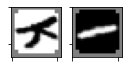

progress label:  10 11 12 
( K(k) L(l) M(m) )
tensor(23, device='cuda:0')


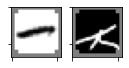

progress label:  8 10 12 
( I(i) K(k) M(m) )
tensor(23, device='cuda:0')


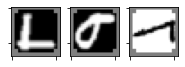

progress label:  19 15 11 7 
( T(t) P(p) L(l) H(h) )
tensor(2, device='cuda:0')


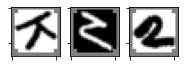

progress label:  10 13 16 19 
( K(k) N(n) Q(q) T(t) )
tensor(11, device='cuda:0')


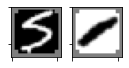

progress label:  13 11 9 
( N(n) L(l) J(j) )
tensor(1, device='cuda:0')


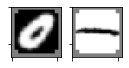

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(1, device='cuda:0')


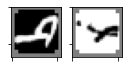

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(1, device='cuda:0')


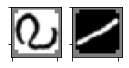

progress label:  6 8 10 
( G(g) I(i) K(k) )
tensor(18, device='cuda:0')


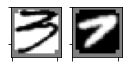

progress label:  22 21 20 
( W(w) V(v) U(u) )
tensor(3, device='cuda:0')


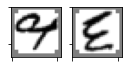

progress label:  6 12 18 
( G(g) M(m) S(s) )
tensor(3, device='cuda:0')


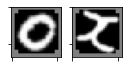

progress label:  14 10 6 
( O(o) K(k) G(g) )
tensor(1, device='cuda:0')


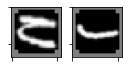

progress label:  13 8 3 
( N(n) I(i) D(d) )
tensor(1, device='cuda:0')


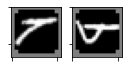

progress label:  17 15 13 
( R(r) P(p) N(n) )
tensor(1, device='cuda:0')


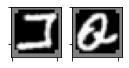

progress label:  22 16 10 
( W(w) Q(q) K(k) )
tensor(5, device='cuda:0')


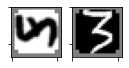

progress label:  25 22 19 
( Z(z) W(w) T(t) )
tensor(5, device='cuda:0')


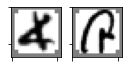

progress label:  0 6 12 
( A(a) G(g) M(m) )
tensor(5, device='cuda:0')


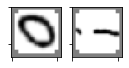

progress label:  14 9 4 
( O(o) J(j) E(e) )
tensor(5, device='cuda:0')


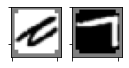

progress label:  7 11 15 
( H(h) L(l) P(p) )
tensor(5, device='cuda:0')


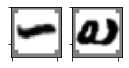

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(4, device='cuda:0')


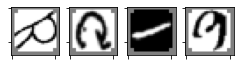

progress label:  1 6 11 16 21 
( B(b) G(g) L(l) Q(q) V(v) )
tensor(2, device='cuda:0')


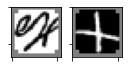

progress label:  24 19 14 
( Y(y) T(t) O(o) )
tensor(4, device='cuda:0')


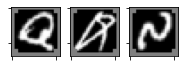

progress label:  16 18 20 22 
( Q(q) S(s) U(u) W(w) )
tensor(20, device='cuda:0')


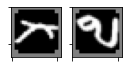

progress label:  10 6 2 
( K(k) G(g) C(c) )
tensor(3, device='cuda:0')


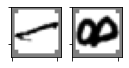

progress label:  8 6 4 
( I(i) G(g) E(e) )
tensor(20, device='cuda:0')


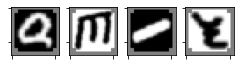

progress label:  0 4 8 12 16 
( A(a) E(e) I(i) M(m) Q(q) )
tensor(1, device='cuda:0')


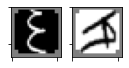

progress label:  12 7 2 
( M(m) H(h) C(c) )
tensor(20, device='cuda:0')


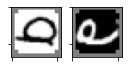

progress label:  3 6 9 
( D(d) G(g) J(j) )
tensor(20, device='cuda:0')


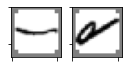

progress label:  11 16 21 
( L(l) Q(q) V(v) )
tensor(15, device='cuda:0')


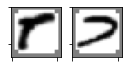

progress label:  17 20 23 
( R(r) U(u) X(x) )
tensor(12, device='cuda:0')


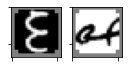

progress label:  12 6 0 
( M(m) G(g) A(a) )
tensor(12, device='cuda:0')


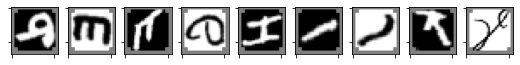

progress label:  3 4 5 6 7 8 9 10 11 12 
( D(d) E(e) F(f) G(g) H(h) I(i) J(j) K(k) L(l) M(m) )
tensor(17, device='cuda:0')


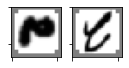

progress label:  18 13 8 
( S(s) N(n) I(i) )
tensor(7, device='cuda:0')


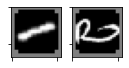

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(19, device='cuda:0')


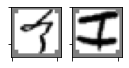

progress label:  1 7 13 
( B(b) H(h) N(n) )
tensor(19, device='cuda:0')


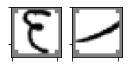

progress label:  12 8 4 
( M(m) I(i) E(e) )
tensor(19, device='cuda:0')


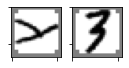

progress label:  24 22 20 
( Y(y) W(w) U(u) )
tensor(22, device='cuda:0')


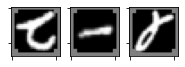

progress label:  7 11 15 19 
( H(h) L(l) P(p) T(t) )
tensor(24, device='cuda:0')


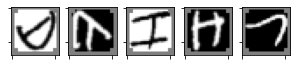

progress label:  3 5 7 9 11 13 
( D(d) F(f) H(h) J(j) L(l) N(n) )
tensor(3, device='cuda:0')


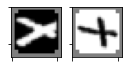

progress label:  23 19 15 
( X(x) T(t) P(p) )
tensor(19, device='cuda:0')


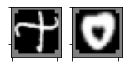

progress label:  5 3 1 
( F(f) D(d) B(b) )
tensor(19, device='cuda:0')


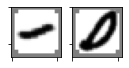

progress label:  8 14 20 
( I(i) O(o) U(u) )
tensor(19, device='cuda:0')


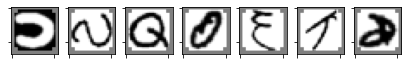

progress label:  20 18 16 14 12 10 8 6 
( U(u) S(s) Q(q) O(o) M(m) K(k) I(i) G(g) )
tensor(14, device='cuda:0')


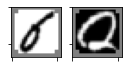

progress label:  15 19 23 
( P(p) T(t) X(x) )
tensor(8, device='cuda:0')


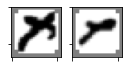

progress label:  23 17 11 
( X(x) R(r) L(l) )
tensor(8, device='cuda:0')


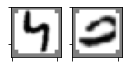

progress label:  25 21 17 
( Z(z) V(v) R(r) )
tensor(10, device='cuda:0')


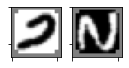

progress label:  21 18 15 
( V(v) S(s) P(p) )
tensor(10, device='cuda:0')


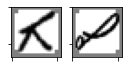

progress label:  10 16 22 
( K(k) Q(q) W(w) )
tensor(25, device='cuda:0')


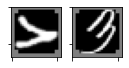

progress label:  21 22 23 
( V(v) W(w) X(x) )
tensor(0, device='cuda:0')


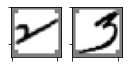

progress label:  24 22 20 
( Y(y) W(w) U(u) )
tensor(0, device='cuda:0')


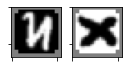

progress label:  25 23 21 
( Z(z) X(x) V(v) )
tensor(10, device='cuda:0')


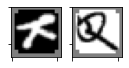

progress label:  10 16 22 
( K(k) Q(q) W(w) )
tensor(10, device='cuda:0')


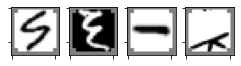

progress label:  13 12 11 10 9 
( N(n) M(m) L(l) K(k) J(j) )
tensor(25, device='cuda:0')


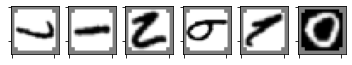

progress label:  9 11 13 15 17 19 21 
( J(j) L(l) N(n) P(p) R(r) T(t) V(v) )
tensor(5, device='cuda:0')


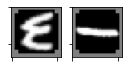

progress label:  12 8 4 
( M(m) I(i) E(e) )
tensor(6, device='cuda:0')


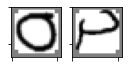

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(6, device='cuda:0')


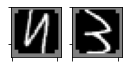

progress label:  25 22 19 
( Z(z) W(w) T(t) )
tensor(6, device='cuda:0')


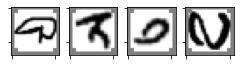

progress label:  6 10 14 18 22 
( G(g) K(k) O(o) S(s) W(w) )
tensor(18, device='cuda:0')


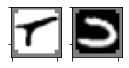

progress label:  17 21 25 
( R(r) V(v) Z(z) )
tensor(6, device='cuda:0')


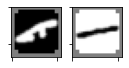

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(21, device='cuda:0')


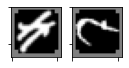

progress label:  7 5 3 
( H(h) F(f) D(d) )
tensor(9, device='cuda:0')


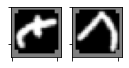

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(20, device='cuda:0')


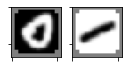

progress label:  14 11 8 
( O(o) L(l) I(i) )
tensor(20, device='cuda:0')


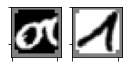

progress label:  6 11 16 
( G(g) L(l) Q(q) )
tensor(20, device='cuda:0')


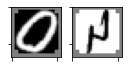

progress label:  14 9 4 
( O(o) J(j) E(e) )
tensor(21, device='cuda:0')


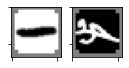

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(21, device='cuda:0')


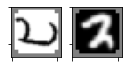

progress label:  24 20 16 
( Y(y) U(u) Q(q) )
tensor(21, device='cuda:0')


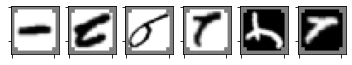

progress label:  11 13 15 17 19 21 23 
( L(l) N(n) P(p) R(r) T(t) V(v) X(x) )
tensor(1, device='cuda:0')


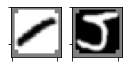

progress label:  8 13 18 
( I(i) N(n) S(s) )
tensor(23, device='cuda:0')


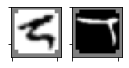

progress label:  7 11 15 
( H(h) L(l) P(p) )
tensor(23, device='cuda:0')


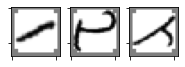

progress label:  11 9 7 5 
( L(l) J(j) H(h) F(f) )
tensor(9, device='cuda:0')


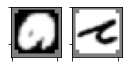

progress label:  4 7 10 
( E(e) H(h) K(k) )
tensor(15, device='cuda:0')


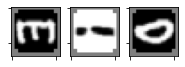

progress label:  4 9 14 19 
( E(e) J(j) O(o) T(t) )
tensor(21, device='cuda:0')


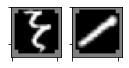

progress label:  12 8 4 
( M(m) I(i) E(e) )
tensor(25, device='cuda:0')


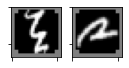

progress label:  12 16 20 
( M(m) Q(q) U(u) )
tensor(25, device='cuda:0')


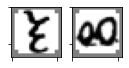

progress label:  12 6 0 
( M(m) G(g) A(a) )
tensor(25, device='cuda:0')


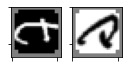

progress label:  5 6 7 
( F(f) G(g) H(h) )
tensor(0, device='cuda:0')


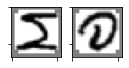

progress label:  12 6 0 
( M(m) G(g) A(a) )
tensor(12, device='cuda:0')


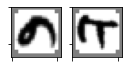

progress label:  4 5 6 
( E(e) F(f) G(g) )
tensor(4, device='cuda:0')


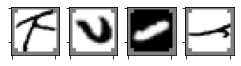

progress label:  10 9 8 7 6 
( K(k) J(j) I(i) H(h) G(g) )
tensor(10, device='cuda:0')


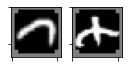

progress label:  2 5 8 
( C(c) F(f) I(i) )
tensor(5, device='cuda:0')


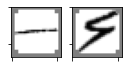

progress label:  11 13 15 
( L(l) N(n) P(p) )
tensor(5, device='cuda:0')


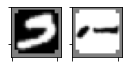

progress label:  13 9 5 
( N(n) J(j) F(f) )
tensor(5, device='cuda:0')


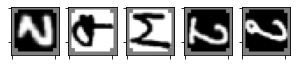

progress label:  18 15 12 9 6 3 
( S(s) P(p) M(m) J(j) G(g) D(d) )
tensor(16, device='cuda:0')


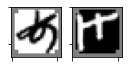

progress label:  10 5 0 
( K(k) F(f) A(a) )
tensor(5, device='cuda:0')


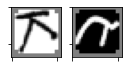

progress label:  10 5 0 
( K(k) F(f) A(a) )
tensor(5, device='cuda:0')


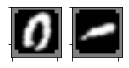

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(5, device='cuda:0')


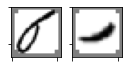

progress label:  15 9 3 
( P(p) J(j) D(d) )
tensor(5, device='cuda:0')


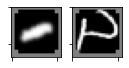

progress label:  11 9 7 
( L(l) J(j) H(h) )
tensor(16, device='cuda:0')


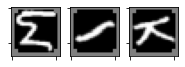

progress label:  12 11 10 9 
( M(m) L(l) K(k) J(j) )
tensor(25, device='cuda:0')


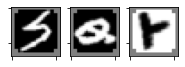

progress label:  13 16 19 22 
( N(n) Q(q) T(t) W(w) )
tensor(25, device='cuda:0')


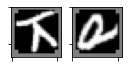

progress label:  10 16 22 
( K(k) Q(q) W(w) )
tensor(3, device='cuda:0')


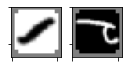

progress label:  11 7 3 
( L(l) H(h) D(d) )
tensor(3, device='cuda:0')


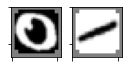

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(3, device='cuda:0')


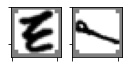

progress label:  12 16 20 
( M(m) Q(q) U(u) )
tensor(5, device='cuda:0')


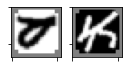

progress label:  15 10 5 
( P(p) K(k) F(f) )
tensor(20, device='cuda:0')


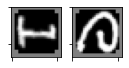

progress label:  8 6 4 
( I(i) G(g) E(e) )
tensor(20, device='cuda:0')


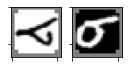

progress label:  18 15 12 
( S(s) P(p) M(m) )
tensor(20, device='cuda:0')


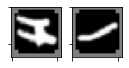

progress label:  7 11 15 
( H(h) L(l) P(p) )
tensor(16, device='cuda:0')


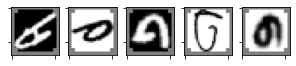

progress label:  0 1 2 3 4 5 
( A(a) B(b) C(c) D(d) E(e) F(f) )
tensor(19, device='cuda:0')


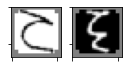

progress label:  7 12 17 
( H(h) M(m) R(r) )
tensor(16, device='cuda:0')


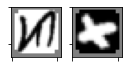

progress label:  25 23 21 
( Z(z) X(x) V(v) )
tensor(16, device='cuda:0')


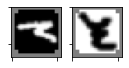

progress label:  7 12 17 
( H(h) M(m) R(r) )
tensor(16, device='cuda:0')


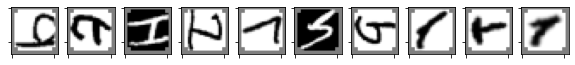

progress label:  3 5 7 9 11 13 15 17 19 21 23 
( D(d) F(f) H(h) J(j) L(l) N(n) P(p) R(r) T(t) V(v) X(x) )
tensor(5, device='cuda:0')


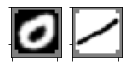

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(1, device='cuda:0')


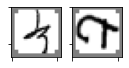

progress label:  7 5 3 
( H(h) F(f) D(d) )
tensor(1, device='cuda:0')


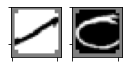

progress label:  11 14 17 
( L(l) O(o) R(r) )
tensor(1, device='cuda:0')


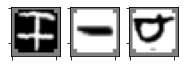

progress label:  7 11 15 19 
( H(h) L(l) P(p) T(t) )
tensor(21, device='cuda:0')


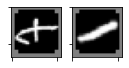

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(1, device='cuda:0')


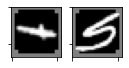

progress label:  19 13 7 
( T(t) N(n) H(h) )
tensor(3, device='cuda:0')


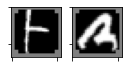

progress label:  19 16 13 
( T(t) Q(q) N(n) )
tensor(3, device='cuda:0')


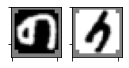

progress label:  4 2 0 
( E(e) C(c) A(a) )
tensor(3, device='cuda:0')


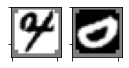

progress label:  6 3 0 
( G(g) D(d) A(a) )
tensor(3, device='cuda:0')


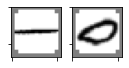

progress label:  8 14 20 
( I(i) O(o) U(u) )
tensor(3, device='cuda:0')


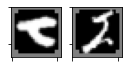

progress label:  7 12 17 
( H(h) M(m) R(r) )
tensor(3, device='cuda:0')


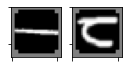

progress label:  11 13 15 
( L(l) N(n) P(p) )
tensor(10, device='cuda:0')


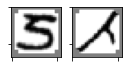

progress label:  13 7 1 
( N(n) H(h) B(b) )
tensor(10, device='cuda:0')


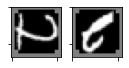

progress label:  9 15 21 
( J(j) P(p) V(v) )
tensor(5, device='cuda:0')


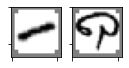

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(18, device='cuda:0')


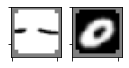

progress label:  9 14 19 
( J(j) O(o) T(t) )
tensor(19, device='cuda:0')


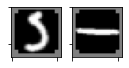

progress label:  13 8 3 
( N(n) I(i) D(d) )
tensor(19, device='cuda:0')


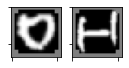

progress label:  3 8 13 
( D(d) I(i) N(n) )
tensor(19, device='cuda:0')


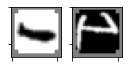

progress label:  8 9 10 
( I(i) J(j) K(k) )
tensor(24, device='cuda:0')


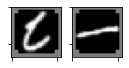

progress label:  13 11 9 
( N(n) L(l) J(j) )
tensor(24, device='cuda:0')


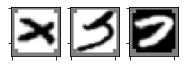

progress label:  23 22 21 20 
( X(x) W(w) V(v) U(u) )
tensor(5, device='cuda:0')


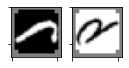

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(5, device='cuda:0')


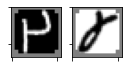

progress label:  9 15 21 
( J(j) P(p) V(v) )
tensor(6, device='cuda:0')


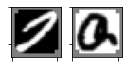

progress label:  20 16 12 
( U(u) Q(q) M(m) )
tensor(6, device='cuda:0')


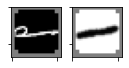

progress label:  16 11 6 
( Q(q) L(l) G(g) )
tensor(6, device='cuda:0')


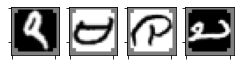

progress label:  0 3 6 9 12 
( A(a) D(d) G(g) J(j) M(m) )
tensor(8, device='cuda:0')


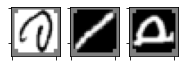

progress label:  6 11 16 21 
( G(g) L(l) Q(q) V(v) )
tensor(15, device='cuda:0')


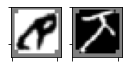

progress label:  6 10 14 
( G(g) K(k) O(o) )
tensor(13, device='cuda:0')


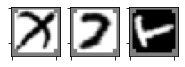

progress label:  23 21 19 17 
( X(x) V(v) T(t) R(r) )
tensor(15, device='cuda:0')


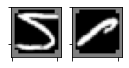

progress label:  13 8 3 
( N(n) I(i) D(d) )
tensor(13, device='cuda:0')


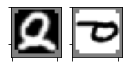

progress label:  0 1 2 
( A(a) B(b) C(c) )
tensor(12, device='cuda:0')


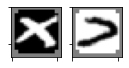

progress label:  23 24 25 
( X(x) Y(y) Z(z) )
tensor(18, device='cuda:0')


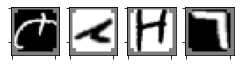

progress label:  5 7 9 11 13 
( F(f) H(h) J(j) L(l) N(n) )
tensor(21, device='cuda:0')


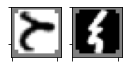

progress label:  17 12 7 
( R(r) M(m) H(h) )
tensor(0, device='cuda:0')


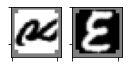

progress label:  16 12 8 
( Q(q) M(m) I(i) )
tensor(0, device='cuda:0')


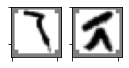

progress label:  7 10 13 
( H(h) K(k) N(n) )
tensor(0, device='cuda:0')


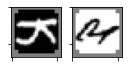

progress label:  10 16 22 
( K(k) Q(q) W(w) )
tensor(22, device='cuda:0')


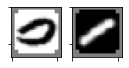

progress label:  14 11 8 
( O(o) L(l) I(i) )
tensor(22, device='cuda:0')


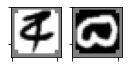

progress label:  0 1 2 
( A(a) B(b) C(c) )
tensor(22, device='cuda:0')


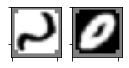

progress label:  18 14 10 
( S(s) O(o) K(k) )
tensor(5, device='cuda:0')


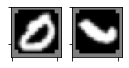

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(5, device='cuda:0')


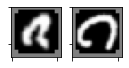

progress label:  0 2 4 
( A(a) C(c) E(e) )
tensor(5, device='cuda:0')


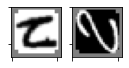

progress label:  13 18 23 
( N(n) S(s) X(x) )
tensor(16, device='cuda:0')


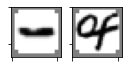

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(16, device='cuda:0')


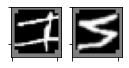

progress label:  7 13 19 
( H(h) N(n) T(t) )
tensor(17, device='cuda:0')


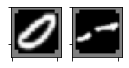

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(8, device='cuda:0')


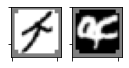

progress label:  10 16 22 
( K(k) Q(q) W(w) )
tensor(3, device='cuda:0')


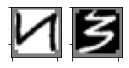

progress label:  25 22 19 
( Z(z) W(w) T(t) )
tensor(3, device='cuda:0')


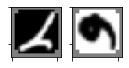

progress label:  8 4 0 
( I(i) E(e) A(a) )
tensor(3, device='cuda:0')


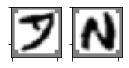

progress label:  21 18 15 
( V(v) S(s) P(p) )
tensor(3, device='cuda:0')


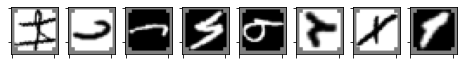

progress label:  7 9 11 13 15 17 19 21 23 
( H(h) J(j) L(l) N(n) P(p) R(r) T(t) V(v) X(x) )
tensor(2, device='cuda:0')


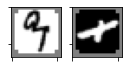

progress label:  16 19 22 
( Q(q) T(t) W(w) )
tensor(13, device='cuda:0')


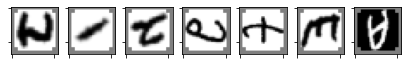

progress label:  9 8 7 6 5 4 3 2 
( J(j) I(i) H(h) G(g) F(f) E(e) D(d) C(c) )
tensor(18, device='cuda:0')


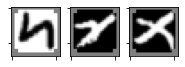

progress label:  25 24 23 22 
( Z(z) Y(y) X(x) W(w) )
tensor(25, device='cuda:0')


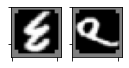

progress label:  12 6 0 
( M(m) G(g) A(a) )
tensor(8, device='cuda:0')


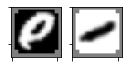

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(10, device='cuda:0')


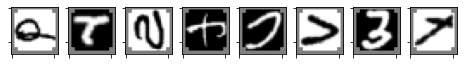

progress label:  16 17 18 19 20 21 22 23 24 
( Q(q) R(r) S(s) T(t) U(u) V(v) W(w) X(x) Y(y) )
tensor(15, device='cuda:0')


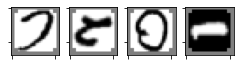

progress label:  20 17 14 11 8 
( U(u) R(r) O(o) L(l) I(i) )
tensor(9, device='cuda:0')


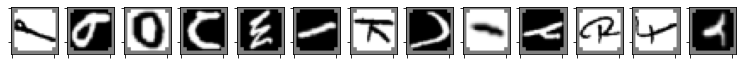

progress label:  16 15 14 13 12 11 10 9 8 7 6 5 4 3 
( Q(q) P(p) O(o) N(n) M(m) L(l) K(k) J(j) I(i) H(h) G(g) F(f) E(e) D(d) )
tensor(20, device='cuda:0')


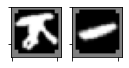

progress label:  10 11 12 
( K(k) L(l) M(m) )
tensor(5, device='cuda:0')


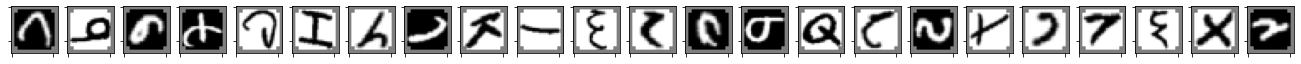

progress label:  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
( C(c) D(d) E(e) F(f) G(g) H(h) I(i) J(j) K(k) L(l) M(m) N(n) O(o) P(p) Q(q) R(r) S(s) T(t) U(u) V(v) W(w) X(x) Y(y) Z(z) )
tensor(9, device='cuda:0')


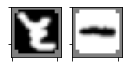

progress label:  12 8 4 
( M(m) I(i) E(e) )
tensor(15, device='cuda:0')


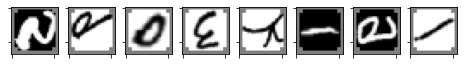

progress label:  18 16 14 12 10 8 6 4 2 
( S(s) Q(q) O(o) M(m) K(k) I(i) G(g) E(e) C(c) )
tensor(20, device='cuda:0')


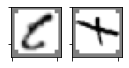

progress label:  13 19 25 
( N(n) T(t) Z(z) )
tensor(4, device='cuda:0')


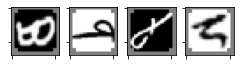

progress label:  1 3 5 7 9 
( B(b) D(d) F(f) H(h) J(j) )
tensor(5, device='cuda:0')


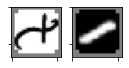

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(6, device='cuda:0')


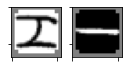

progress label:  7 11 15 
( H(h) L(l) P(p) )
tensor(15, device='cuda:0')


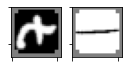

progress label:  5 8 11 
( F(f) I(i) L(l) )
tensor(21, device='cuda:0')


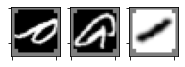

progress label:  1 6 11 16 
( B(b) G(g) L(l) Q(q) )
tensor(2, device='cuda:0')


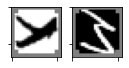

progress label:  24 22 20 
( Y(y) W(w) U(u) )
tensor(24, device='cuda:0')


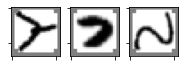

progress label:  24 21 18 15 
( Y(y) V(v) S(s) P(p) )
tensor(16, device='cuda:0')


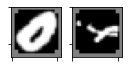

progress label:  14 9 4 
( O(o) J(j) E(e) )
tensor(23, device='cuda:0')


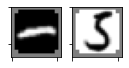

progress label:  11 13 15 
( L(l) N(n) P(p) )
tensor(23, device='cuda:0')


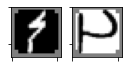

progress label:  13 9 5 
( N(n) J(j) F(f) )
tensor(16, device='cuda:0')


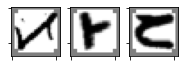

progress label:  25 19 13 7 
( Z(z) T(t) N(n) H(h) )
tensor(6, device='cuda:0')


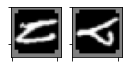

progress label:  13 18 23 
( N(n) S(s) X(x) )
tensor(18, device='cuda:0')


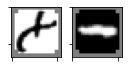

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(18, device='cuda:0')


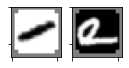

progress label:  8 6 4 
( I(i) G(g) E(e) )
tensor(18, device='cuda:0')


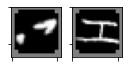

progress label:  8 7 6 
( I(i) H(h) G(g) )
tensor(18, device='cuda:0')


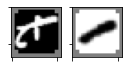

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(7, device='cuda:0')


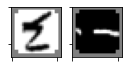

progress label:  12 9 6 
( M(m) J(j) G(g) )
tensor(10, device='cuda:0')


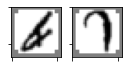

progress label:  0 2 4 
( A(a) C(c) E(e) )
tensor(10, device='cuda:0')


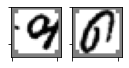

progress label:  6 4 2 
( G(g) E(e) C(c) )
tensor(10, device='cuda:0')


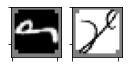

progress label:  16 11 6 
( Q(q) L(l) G(g) )
tensor(1, device='cuda:0')


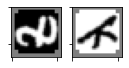

progress label:  5 10 15 
( F(f) K(k) P(p) )
tensor(1, device='cuda:0')


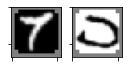

progress label:  17 20 23 
( R(r) U(u) X(x) )
tensor(4, device='cuda:0')


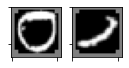

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(4, device='cuda:0')


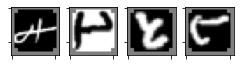

progress label:  5 9 13 17 21 
( F(f) J(j) N(n) R(r) V(v) )
tensor(13, device='cuda:0')


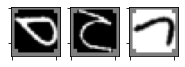

progress label:  3 7 11 15 
( D(d) H(h) L(l) P(p) )
tensor(23, device='cuda:0')


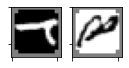

progress label:  11 16 21 
( L(l) Q(q) V(v) )
tensor(1, device='cuda:0')


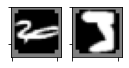

progress label:  24 22 20 
( Y(y) W(w) U(u) )
tensor(1, device='cuda:0')


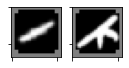

progress label:  8 10 12 
( I(i) K(k) M(m) )
tensor(6, device='cuda:0')


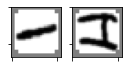

progress label:  11 7 3 
( L(l) H(h) D(d) )
tensor(6, device='cuda:0')


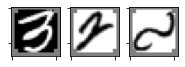

progress label:  22 20 18 16 
( W(w) U(u) S(s) Q(q) )
tensor(15, device='cuda:0')


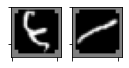

progress label:  13 8 3 
( N(n) I(i) D(d) )
tensor(6, device='cuda:0')


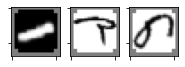

progress label:  8 6 4 2 
( I(i) G(g) E(e) C(c) )
tensor(0, device='cuda:0')


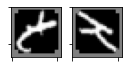

progress label:  5 10 15 
( F(f) K(k) P(p) )
tensor(9, device='cuda:0')


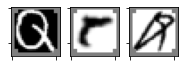

progress label:  16 17 18 19 
( Q(q) R(r) S(s) T(t) )
tensor(21, device='cuda:0')


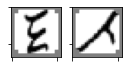

progress label:  12 7 2 
( M(m) H(h) C(c) )
tensor(8, device='cuda:0')


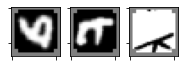

progress label:  0 5 10 15 
( A(a) F(f) K(k) P(p) )
tensor(19, device='cuda:0')


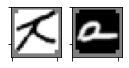

progress label:  10 6 2 
( K(k) G(g) C(c) )
tensor(15, device='cuda:0')


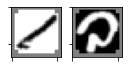

progress label:  8 6 4 
( I(i) G(g) E(e) )
tensor(21, device='cuda:0')


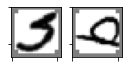

progress label:  1 3 5 
( B(b) D(d) F(f) )
tensor(21, device='cuda:0')


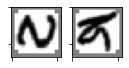

progress label:  18 17 16 
( S(s) R(r) Q(q) )
tensor(21, device='cuda:0')


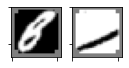

progress label:  15 11 7 
( P(p) L(l) H(h) )
tensor(21, device='cuda:0')


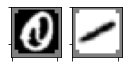

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(20, device='cuda:0')


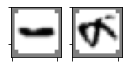

progress label:  11 17 23 
( L(l) R(r) X(x) )
tensor(0, device='cuda:0')


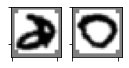

progress label:  8 14 20 
( I(i) O(o) U(u) )
tensor(11, device='cuda:0')


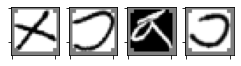

progress label:  23 20 17 14 11 
( X(x) U(u) R(r) O(o) L(l) )
tensor(22, device='cuda:0')


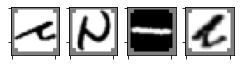

progress label:  7 9 11 13 15 
( H(h) J(j) L(l) N(n) P(p) )
tensor(22, device='cuda:0')


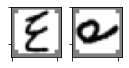

progress label:  12 6 0 
( M(m) G(g) A(a) )
tensor(1, device='cuda:0')


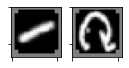

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(1, device='cuda:0')


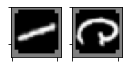

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(20, device='cuda:0')


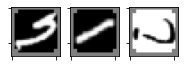

progress label:  13 11 9 7 
( N(n) L(l) J(j) H(h) )
tensor(0, device='cuda:0')


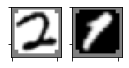

progress label:  20 21 22 
( U(u) V(v) W(w) )
tensor(20, device='cuda:0')


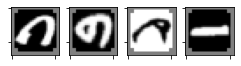

progress label:  2 4 6 8 10 
( C(c) E(e) G(g) I(i) K(k) )
tensor(5, device='cuda:0')


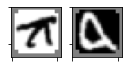

progress label:  10 6 2 
( K(k) G(g) C(c) )
tensor(19, device='cuda:0')


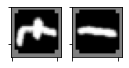

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(19, device='cuda:0')


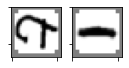

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(14, device='cuda:0')


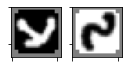

progress label:  24 18 12 
( Y(y) S(s) M(m) )
tensor(14, device='cuda:0')


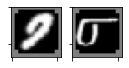

progress label:  20 15 10 
( U(u) P(p) K(k) )
tensor(16, device='cuda:0')


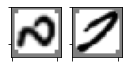

progress label:  18 20 22 
( S(s) U(u) W(w) )
tensor(16, device='cuda:0')


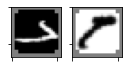

progress label:  21 17 13 
( V(v) R(r) N(n) )
tensor(20, device='cuda:0')


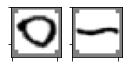

progress label:  14 11 8 
( O(o) L(l) I(i) )
tensor(20, device='cuda:0')


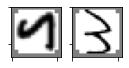

progress label:  25 22 19 
( Z(z) W(w) T(t) )
tensor(20, device='cuda:0')


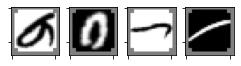

progress label:  17 14 11 8 5 
( R(r) O(o) L(l) I(i) F(f) )
tensor(21, device='cuda:0')


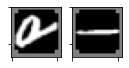

progress label:  6 11 16 
( G(g) L(l) Q(q) )
tensor(1, device='cuda:0')


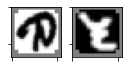

progress label:  6 12 18 
( G(g) M(m) S(s) )
tensor(1, device='cuda:0')


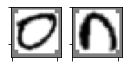

progress label:  3 2 1 
( D(d) C(c) B(b) )
tensor(1, device='cuda:0')


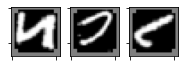

progress label:  25 21 17 13 
( Z(z) V(v) R(r) N(n) )
tensor(17, device='cuda:0')


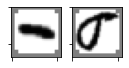

progress label:  11 15 19 
( L(l) P(p) T(t) )
tensor(22, device='cuda:0')


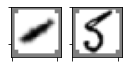

progress label:  8 13 18 
( I(i) N(n) S(s) )
tensor(22, device='cuda:0')


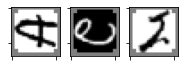

progress label:  0 6 12 18 
( A(a) G(g) M(m) S(s) )
tensor(13, device='cuda:0')


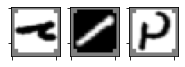

progress label:  7 8 9 10 
( H(h) I(i) J(j) K(k) )
tensor(7, device='cuda:0')


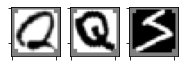

progress label:  19 16 13 10 
( T(t) Q(q) N(n) K(k) )
tensor(7, device='cuda:0')


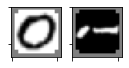

progress label:  14 9 4 
( O(o) J(j) E(e) )
tensor(21, device='cuda:0')


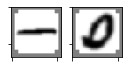

progress label:  8 14 20 
( I(i) O(o) U(u) )
tensor(21, device='cuda:0')


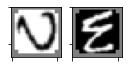

progress label:  18 12 6 
( S(s) M(m) G(g) )
tensor(11, device='cuda:0')


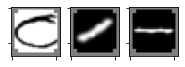

progress label:  14 11 8 5 
( O(o) L(l) I(i) F(f) )
tensor(18, device='cuda:0')


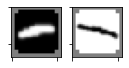

progress label:  11 8 5 
( L(l) I(i) F(f) )
tensor(10, device='cuda:0')


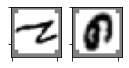

progress label:  7 5 3 
( H(h) F(f) D(d) )
tensor(24, device='cuda:0')


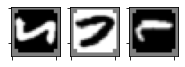

progress label:  25 21 17 13 
( Z(z) V(v) R(r) N(n) )
tensor(21, device='cuda:0')


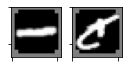

progress label:  8 5 2 
( I(i) F(f) C(c) )
tensor(24, device='cuda:0')


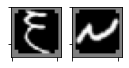

progress label:  12 18 24 
( M(m) S(s) Y(y) )
tensor(24, device='cuda:0')


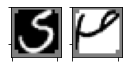

progress label:  13 9 5 
( N(n) J(j) F(f) )
tensor(24, device='cuda:0')


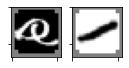

progress label:  16 11 6 
( Q(q) L(l) G(g) )
tensor(16, device='cuda:0')


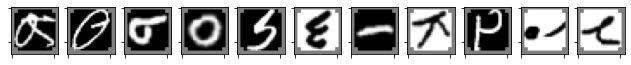

progress label:  17 16 15 14 13 12 11 10 9 8 7 6 
( R(r) Q(q) P(p) O(o) N(n) M(m) L(l) K(k) J(j) I(i) H(h) G(g) )
tensor(25, device='cuda:0')


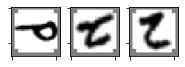

progress label:  1 7 13 19 
( B(b) H(h) N(n) T(t) )
tensor(21, device='cuda:0')


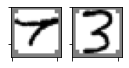

progress label:  21 22 23 
( V(v) W(w) X(x) )
tensor(9, device='cuda:0')


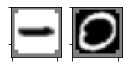

progress label:  11 14 17 
( L(l) O(o) R(r) )
tensor(9, device='cuda:0')


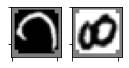

progress label:  2 1 0 
( C(c) B(b) A(a) )
tensor(19, device='cuda:0')


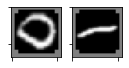

progress label:  14 11 8 
( O(o) L(l) I(i) )
tensor(19, device='cuda:0')


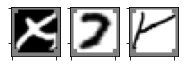

progress label:  23 21 19 17 
( X(x) V(v) T(t) R(r) )
tensor(10, device='cuda:0')


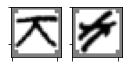

progress label:  10 7 4 
( K(k) H(h) E(e) )
tensor(19, device='cuda:0')


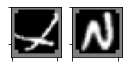

progress label:  23 18 13 
( X(x) S(s) N(n) )
tensor(7, device='cuda:0')


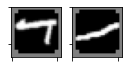

progress label:  11 8 5 
( L(l) I(i) F(f) )
tensor(7, device='cuda:0')


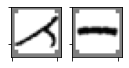

progress label:  7 11 15 
( H(h) L(l) P(p) )
tensor(16, device='cuda:0')


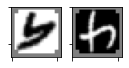

progress label:  21 19 17 
( V(v) T(t) R(r) )
tensor(16, device='cuda:0')


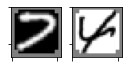

progress label:  21 23 25 
( V(v) X(x) Z(z) )
tensor(16, device='cuda:0')


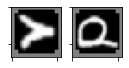

progress label:  21 16 11 
( V(v) Q(q) L(l) )
tensor(20, device='cuda:0')


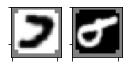

progress label:  20 15 10 
( U(u) P(p) K(k) )
tensor(20, device='cuda:0')


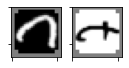

progress label:  2 5 8 
( C(c) F(f) I(i) )
tensor(16, device='cuda:0')


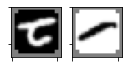

progress label:  7 11 15 
( H(h) L(l) P(p) )
tensor(16, device='cuda:0')


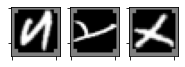

progress label:  25 24 23 22 
( Z(z) Y(y) X(x) W(w) )
tensor(18, device='cuda:0')


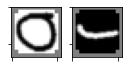

progress label:  3 8 13 
( D(d) I(i) N(n) )
tensor(19, device='cuda:0')


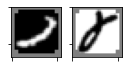

progress label:  9 15 21 
( J(j) P(p) V(v) )
tensor(18, device='cuda:0')


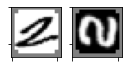

progress label:  20 18 16 
( U(u) S(s) Q(q) )
tensor(18, device='cuda:0')


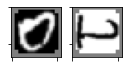

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(16, device='cuda:0')


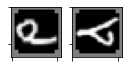

progress label:  16 18 20 
( Q(q) S(s) U(u) )
tensor(16, device='cuda:0')


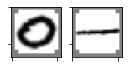

progress label:  14 8 2 
( O(o) I(i) C(c) )
tensor(7, device='cuda:0')


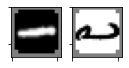

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(16, device='cuda:0')


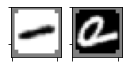

progress label:  8 6 4 
( I(i) G(g) E(e) )
tensor(16, device='cuda:0')


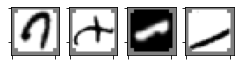

progress label:  2 5 8 11 14 
( C(c) F(f) I(i) L(l) O(o) )
tensor(25, device='cuda:0')


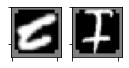

progress label:  13 7 1 
( N(n) H(h) B(b) )
tensor(2, device='cuda:0')


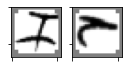

progress label:  22 17 12 
( W(w) R(r) M(m) )
tensor(2, device='cuda:0')


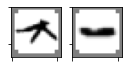

progress label:  10 11 12 
( K(k) L(l) M(m) )
tensor(7, device='cuda:0')


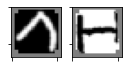

progress label:  11 8 5 
( L(l) I(i) F(f) )
tensor(7, device='cuda:0')


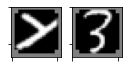

progress label:  24 22 20 
( Y(y) W(w) U(u) )
tensor(22, device='cuda:0')


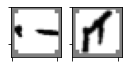

progress label:  9 5 1 
( J(j) F(f) B(b) )
tensor(2, device='cuda:0')


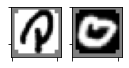

progress label:  6 3 0 
( G(g) D(d) A(a) )
tensor(2, device='cuda:0')


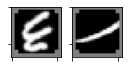

progress label:  12 8 4 
( M(m) I(i) E(e) )
tensor(2, device='cuda:0')


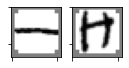

progress label:  11 9 7 
( L(l) J(j) H(h) )
tensor(2, device='cuda:0')


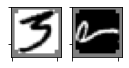

progress label:  22 16 10 
( W(w) Q(q) K(k) )
tensor(2, device='cuda:0')


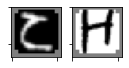

progress label:  13 9 5 
( N(n) J(j) F(f) )
tensor(7, device='cuda:0')


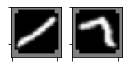

progress label:  8 11 14 
( I(i) L(l) O(o) )
tensor(19, device='cuda:0')


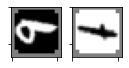

progress label:  15 19 23 
( P(p) T(t) X(x) )
tensor(19, device='cuda:0')


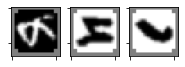

progress label:  17 13 9 5 
( R(r) N(n) J(j) F(f) )
tensor(21, device='cuda:0')


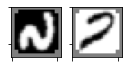

progress label:  18 21 24 
( S(s) V(v) Y(y) )
tensor(20, device='cuda:0')


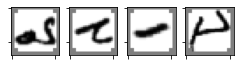

progress label:  6 7 8 9 10 
( G(g) H(h) I(i) J(j) K(k) )
tensor(22, device='cuda:0')


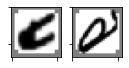

progress label:  0 6 12 
( A(a) G(g) M(m) )
tensor(20, device='cuda:0')


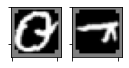

progress label:  16 10 4 
( Q(q) K(k) E(e) )
tensor(20, device='cuda:0')


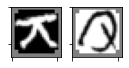

progress label:  10 16 22 
( K(k) Q(q) W(w) )
tensor(16, device='cuda:0')


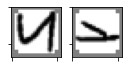

progress label:  25 24 23 
( Z(z) Y(y) X(x) )
tensor(16, device='cuda:0')


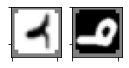

progress label:  4 3 2 
( E(e) D(d) C(c) )
tensor(16, device='cuda:0')


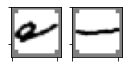

progress label:  6 11 16 
( G(g) L(l) Q(q) )
tensor(16, device='cuda:0')


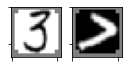

progress label:  22 21 20 
( W(w) V(v) U(u) )
tensor(9, device='cuda:0')


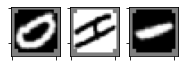

progress label:  3 7 11 15 
( D(d) H(h) L(l) P(p) )
tensor(24, device='cuda:0')


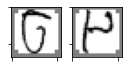

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(8, device='cuda:0')


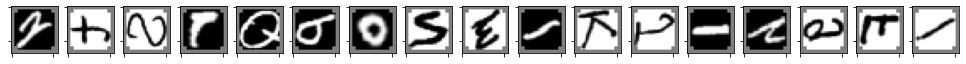

progress label:  20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 
( U(u) T(t) S(s) R(r) Q(q) P(p) O(o) N(n) M(m) L(l) K(k) J(j) I(i) H(h) G(g) F(f) E(e) D(d) )
tensor(10, device='cuda:0')


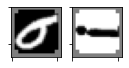

progress label:  15 9 3 
( P(p) J(j) D(d) )
tensor(7, device='cuda:0')


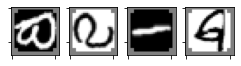

progress label:  1 6 11 16 21 
( B(b) G(g) L(l) Q(q) V(v) )
tensor(3, device='cuda:0')


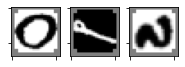

progress label:  14 16 18 20 
( O(o) Q(q) S(s) U(u) )
tensor(24, device='cuda:0')


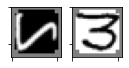

progress label:  25 22 19 
( Z(z) W(w) T(t) )
tensor(6, device='cuda:0')


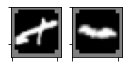

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(5, device='cuda:0')


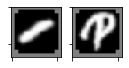

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(19, device='cuda:0')


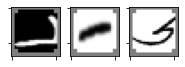

progress label:  9 11 13 15 
( J(j) L(l) N(n) P(p) )
tensor(18, device='cuda:0')


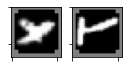

progress label:  23 19 15 
( X(x) T(t) P(p) )
tensor(8, device='cuda:0')


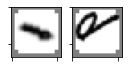

progress label:  11 16 21 
( L(l) Q(q) V(v) )
tensor(8, device='cuda:0')


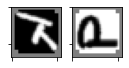

progress label:  10 16 22 
( K(k) Q(q) W(w) )
tensor(8, device='cuda:0')


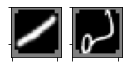

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(19, device='cuda:0')


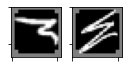

progress label:  7 12 17 
( H(h) M(m) R(r) )
tensor(19, device='cuda:0')


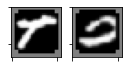

progress label:  17 21 25 
( R(r) V(v) Z(z) )
tensor(19, device='cuda:0')


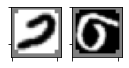

progress label:  21 15 9 
( V(v) P(p) J(j) )
tensor(19, device='cuda:0')


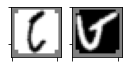

progress label:  13 15 17 
( N(n) P(p) R(r) )
tensor(11, device='cuda:0')


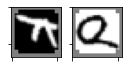

progress label:  10 6 2 
( K(k) G(g) C(c) )
tensor(14, device='cuda:0')


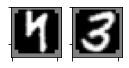

progress label:  25 22 19 
( Z(z) W(w) T(t) )
tensor(14, device='cuda:0')


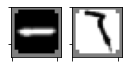

progress label:  11 7 3 
( L(l) H(h) D(d) )
tensor(23, device='cuda:0')


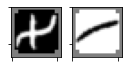

progress label:  5 8 11 
( F(f) I(i) L(l) )
tensor(23, device='cuda:0')


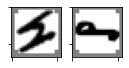

progress label:  12 16 20 
( M(m) Q(q) U(u) )
tensor(23, device='cuda:0')


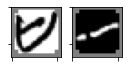

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(9, device='cuda:0')


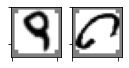

progress label:  0 2 4 
( A(a) C(c) E(e) )
tensor(9, device='cuda:0')


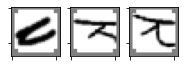

progress label:  13 10 7 4 
( N(n) K(k) H(h) E(e) )
tensor(8, device='cuda:0')


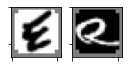

progress label:  12 16 20 
( M(m) Q(q) U(u) )
tensor(8, device='cuda:0')


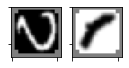

progress label:  18 17 16 
( S(s) R(r) Q(q) )
tensor(8, device='cuda:0')


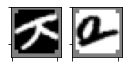

progress label:  10 16 22 
( K(k) Q(q) W(w) )
tensor(15, device='cuda:0')


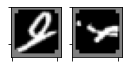

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(12, device='cuda:0')


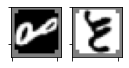

progress label:  16 12 8 
( Q(q) M(m) I(i) )
tensor(12, device='cuda:0')


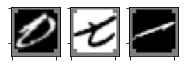

progress label:  3 7 11 15 
( D(d) H(h) L(l) P(p) )
tensor(4, device='cuda:0')


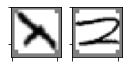

progress label:  19 20 21 
( T(t) U(u) V(v) )
tensor(14, device='cuda:0')


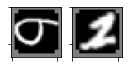

progress label:  15 20 25 
( P(p) U(u) Z(z) )
tensor(20, device='cuda:0')


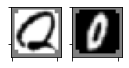

progress label:  19 14 9 
( T(t) O(o) J(j) )
tensor(20, device='cuda:0')


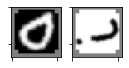

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(20, device='cuda:0')


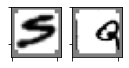

progress label:  13 16 19 
( N(n) Q(q) T(t) )
tensor(20, device='cuda:0')


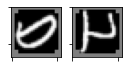

progress label:  3 9 15 
( D(d) J(j) P(p) )
tensor(1, device='cuda:0')


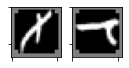

progress label:  5 11 17 
( F(f) L(l) R(r) )
tensor(1, device='cuda:0')


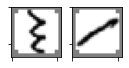

progress label:  12 8 4 
( M(m) I(i) E(e) )
tensor(1, device='cuda:0')


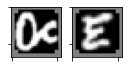

progress label:  16 12 8 
( Q(q) M(m) I(i) )
tensor(1, device='cuda:0')


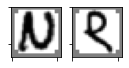

progress label:  18 16 14 
( S(s) Q(q) O(o) )
tensor(1, device='cuda:0')


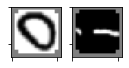

progress label:  14 9 4 
( O(o) J(j) E(e) )
tensor(18, device='cuda:0')


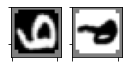

progress label:  0 1 2 
( A(a) B(b) C(c) )
tensor(1, device='cuda:0')


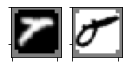

progress label:  21 15 9 
( V(v) P(p) J(j) )
tensor(1, device='cuda:0')


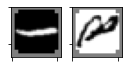

progress label:  11 16 21 
( L(l) Q(q) V(v) )
tensor(1, device='cuda:0')


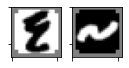

progress label:  12 18 24 
( M(m) S(s) Y(y) )
tensor(21, device='cuda:0')


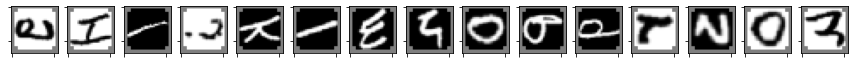

progress label:  6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
( G(g) H(h) I(i) J(j) K(k) L(l) M(m) N(n) O(o) P(p) Q(q) R(r) S(s) T(t) U(u) V(v) )
tensor(0, device='cuda:0')


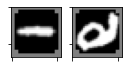

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(1, device='cuda:0')


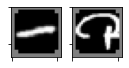

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(5, device='cuda:0')


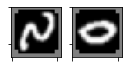

progress label:  20 14 8 
( U(u) O(o) I(i) )
tensor(20, device='cuda:0')


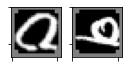

progress label:  0 3 6 
( A(a) D(d) G(g) )
tensor(22, device='cuda:0')


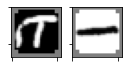

progress label:  5 8 11 
( F(f) I(i) L(l) )
tensor(22, device='cuda:0')


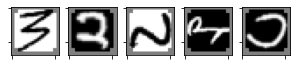

progress label:  22 20 18 16 14 12 
( W(w) U(u) S(s) Q(q) O(o) M(m) )
tensor(21, device='cuda:0')


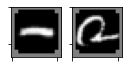

progress label:  11 6 1 
( L(l) G(g) B(b) )
tensor(22, device='cuda:0')


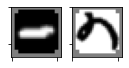

progress label:  8 4 0 
( I(i) E(e) A(a) )
tensor(11, device='cuda:0')


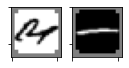

progress label:  16 11 6 
( Q(q) L(l) G(g) )
tensor(11, device='cuda:0')


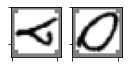

progress label:  18 14 10 
( S(s) O(o) K(k) )
tensor(20, device='cuda:0')


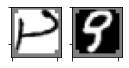

progress label:  9 14 19 
( J(j) O(o) T(t) )
tensor(10, device='cuda:0')


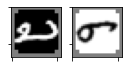

progress label:  9 15 21 
( J(j) P(p) V(v) )
tensor(10, device='cuda:0')


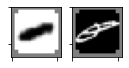

progress label:  11 15 19 
( L(l) P(p) T(t) )
tensor(8, device='cuda:0')


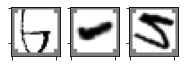

progress label:  3 8 13 18 
( D(d) I(i) N(n) S(s) )
tensor(16, device='cuda:0')


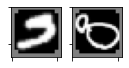

progress label:  13 16 19 
( N(n) Q(q) T(t) )
tensor(8, device='cuda:0')


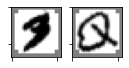

progress label:  22 16 10 
( W(w) Q(q) K(k) )
tensor(8, device='cuda:0')


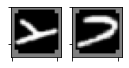

progress label:  24 20 16 
( Y(y) U(u) Q(q) )
tensor(25, device='cuda:0')


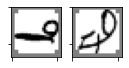

progress label:  3 5 7 
( D(d) F(f) H(h) )
tensor(17, device='cuda:0')


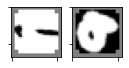

progress label:  9 15 21 
( J(j) P(p) V(v) )
tensor(17, device='cuda:0')


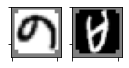

progress label:  4 3 2 
( E(e) D(d) C(c) )
tensor(9, device='cuda:0')


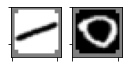

progress label:  8 14 20 
( I(i) O(o) U(u) )
tensor(9, device='cuda:0')


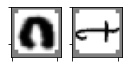

progress label:  2 5 8 
( C(c) F(f) I(i) )
tensor(5, device='cuda:0')


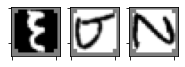

progress label:  12 15 18 21 
( M(m) P(p) S(s) V(v) )
tensor(16, device='cuda:0')
Valid accuracy: 95.25


In [46]:
load_path='./drive/MyDrive/final_proj_colab/normal/model_normal.pt'
eval(valid_dl, load_path)

### Test code for grading by TA

In [ ]:
# you do not need to modify here
from data_utils import Mydataset, collate_fn

test_path = './data/emnist_progress_easy_data/test'
test_ds = Mydataset(test_path, transform=transform, train=False)
test_dl= DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [ ]:
# please change the model name to your submission model name
load_path = './model_normal.pt'
eval(test_dl, load_path)